**Imports**

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import zlib
import pickle
import os
import matplotlib.pyplot as plt
from itertools import combinations
import sys
import math
from collections import Counter
from scipy.stats import zscore


compressed_sizes = {}


**Load dataset**

In [2]:
def load_dataset(file_path):
    df = pd.read_csv(file_path, sep="::", engine="python", names=["user_id", "item_id", "rating", "timestamp", "normalized_rating"])
    return df

**Dictionary with pre-computed values**

In [3]:
def compute_compressed_sizes(user_ratings):
    
    for user, ratings in user_ratings.items():
        u_string = "".join(f"{k}:{v} " for k, v in sorted(ratings.items()))
        compressed_sizes[u_string] = len(zlib.compress(u_string.encode()))
    
    return compressed_sizes


**Similarities**

In [4]:
def linear_similarity(ratings_u, ratings_v):
    common_items = set(ratings_u.keys()).intersection(set(ratings_v.keys()))
    if not common_items:
        return 0  # If no common items, similarity is 0

    diff_sum = sum(abs(ratings_u[i] - ratings_v[i]) for i in common_items)
    ls_value = 1 - (diff_sum / len(common_items))
    return max(0, ls_value)  # Ensure similarity is non-negative

# Compression Similarity with precomputed sizes
def compression_similarity(ratings_u, ratings_v):
    u_string = "".join(f"{k}:{v} " for k, v in sorted(ratings_u.items()))
    v_string = "".join(f"{k}:{v} " for k, v in sorted(ratings_v.items()))
    c_uv = len(zlib.compress((u_string + v_string).encode()))
    c_u = compressed_sizes[u_string]
    c_v = compressed_sizes[v_string]
    return 1 - (c_uv - min(c_u, c_v)) / max(c_u, c_v)

# Kolmogorov Similarity with precomputed sizes
def kolmogorov_similarity(ratings_u, ratings_v):
    #ordena a priori os ratings dado por cada user
    u_string = "".join(f"{k}:{v} " for k, v in sorted(ratings_u.items()))
    v_string = "".join(f"{k}:{v} " for k, v in sorted(ratings_v.items()))
    c_u = compressed_sizes[u_string]
    c_v = compressed_sizes[v_string]
    return 1 / (1 + abs(c_u - c_v))


**Simlarity Matrix and graph**

In [34]:
# Compute user similarity matrix and construct graph (with precomputed sizes)
def compute_similarity_matrix(user_ratings, similarity_measure, compressed_sizes):
    similarity_graph = nx.Graph()

    # Step 1: Add all users as nodes (ensures isolated users are included)
    similarity_graph.add_nodes_from(user_ratings.keys())

    # Step 2: Compute pairwise similarities and add edges if similarity > 0.99
    for (u, v) in combinations(user_ratings.keys(), 2):
        sim = similarity_measure(user_ratings[u], user_ratings[v])
        if sim > 0.9:
            similarity_graph.add_edge(u, v, weight=sim)

    return similarity_graph

# Detect user clusters from similarity graph
def detect_groups(similarity_graph,min_cluster_size):
    """ Detect user clusters from similarity graph and assign small clusters to a complementary cluster. """
    clusters = list(nx.connected_components(similarity_graph))
    complementary_cluster = set()
    filtered_clusters = []

    for cluster in clusters:
        if len(cluster) < min_cluster_size:
            complementary_cluster.update(cluster)  # Add small clusters to the complementary cluster
        else:
            filtered_clusters.append(cluster)  # Keep large clusters as they are

    if complementary_cluster:
        filtered_clusters.append(complementary_cluster)  # Add complementary cluster if it has users

    filtered_cluster_sizes = [len(group) for group in filtered_clusters]
    print("Number of clusters: ", len(filtered_clusters))
    print("complementary_cluster: ", len(complementary_cluster))
    mean_size = np.mean(filtered_cluster_sizes)
    std_size = np.std(filtered_cluster_sizes)
    z_score = (len(complementary_cluster) - mean_size) / std_size if std_size > 0 else float('inf')
    print("z_score: ", z_score)

    return filtered_clusters

**Reputation-based intra-clustering**

In [30]:
def compute_cluster_ratings(df, user_groups):
    """ Compute initial ratings per cluster based only on the items rated by at least 5 users in the cluster. """
    cluster_item_ratings = {}

    # Iterate through each user cluster
    for cluster_idx, user_set in enumerate(user_groups, start=1): 
        cluster_df = df[df["user_id"].isin(user_set)]  # Filter dataset to only include users in the cluster
        item_rating_counts = cluster_df["item_id"].value_counts()  # Count ratings per item
        
        # Filter items that have at least x ratings
        #TODO
        valid_items = item_rating_counts[item_rating_counts >= 1].index  

        # Compute the mean only for valid items
        filtered_avg_ratings = cluster_df[cluster_df["item_id"].isin(valid_items)].groupby("item_id")["normalized_rating"].mean().to_dict()

        cluster_item_ratings[cluster_idx] = filtered_avg_ratings

    return cluster_item_ratings


def compute_reputation_adjusted_ratings(df, cluster_item_ratings, user_groups, lambda_factor=0.95, tol=1e-2):
    """ Iteratively adjust ratings based on user reputation until convergence. """

    # Sort clusters based on size (number of items rated) in descending order.
    clusters = cluster_item_ratings.keys()

    # Initialize previous ratings with the initial ratings for the top clusters.
    prev_ratings = {c: cluster_item_ratings[c].copy() for c in clusters}

    converged = False

    # Iterate until convergence (ratings dont change after one iteration).
    while not converged:
        new_ratings = {}  
        converged = True 

        # Iterate through each of the top clusters.
        for cluster in clusters:
            # Get all user IDs belonging to the current cluster.
            cluster_users = user_groups[cluster - 1]  # -1 because user_groups is zero indexed but cluster index starts at 1.

            # Filter the DataFrame to include only ratings from users in the current cluster.
            cluster_df = df[df["user_id"].isin(cluster_users)]

            # Copy the previous ratings for this cluster to use as a starting point.
            item_ratings = prev_ratings[cluster].copy()

            user_reputation = {}  # Store the reputation scores for users in this cluster.

            # Compute reputation scores for each user in the cluster.
            for user in cluster_users:
                # Filter the cluster's DataFrame to get ratings from the current user.
                user_ratings = cluster_df[cluster_df["user_id"] == user]

                # Calculate the total difference between the user's ratings and the current item ratings.
                errors = [abs(user_ratings[user_ratings["item_id"] == item]["normalized_rating"].values[0] - item_ratings[item])
                         for item in user_ratings["item_id"] if item in item_ratings]
                          
                # Calculate the total error, divided by number of ratings the user has.
                avg_error = np.sum(errors) / len(user_ratings) if errors else 0

                # Calculate the user's reputation score. Ensure it's non-negative.
                user_reputation[user] = max(0, 1 - lambda_factor * abs(avg_error))

            # Compute new weighted averages for item ratings based on user reputations.
            new_item_ratings = item_ratings.copy()  # Start with existing ratings.

            # Iterate through each item in the cluster's item ratings.
            for item in item_ratings.keys():
                # Filter the cluster's DataFrame to get ratings for the current item.
                ratings = cluster_df[cluster_df["item_id"] == item]

                # Extract the reputation weights and rating values for users who rated the current item.
                weights = np.array([user_reputation[user] for user in ratings["user_id"] if user in user_reputation])
                 
                values = np.array([ratings[ratings["user_id"] == user]["normalized_rating"].values[0] for user in ratings["user_id"] if user in user_reputation])
       
                # Calculate the new weighted average rating for the item.
                if len(weights) > 0 and sum(weights) > 0:
                    new_item_ratings[item] = min(1.0, np.dot(weights, values) /  np.sum(weights))

            # Store the new item ratings for the cluster.
            new_ratings[cluster] = new_item_ratings

            # Check for convergence: compare new ratings with previous ratings.
            print("ITERATION")
            for item in new_item_ratings.keys():
                # If the difference between the new rating and the previous rating exceeds the tolerance,
                # set the convergence flag to False.
                if abs(new_item_ratings[item] - prev_ratings[cluster].get(item, 0)) > tol:
                    converged = False

        # Update the previous ratings with the newly computed ratings for the next iteration.
        prev_ratings = new_ratings.copy()

    # Print the final converged ratings.
    print("new_ratings: ", new_ratings)

    # Return the converged ratings.
    return new_ratings

def compute_weighted_average_cluster_ratings(cluster_item_ratings, user_groups):
    """Compute weighted average ratings for each item across clusters using cluster size as weight."""
    item_weighted_sums = {}
    item_total_weights = {}
    
    # Iterate over clusters and their item ratings
    for cluster_idx, item_ratings in cluster_item_ratings.items():
        cluster_size = len(user_groups[cluster_idx - 1])  # Cluster index is 1-based, user_groups is 0-based
        
        for item, rating in item_ratings.items():
            if item not in item_weighted_sums:
                item_weighted_sums[item] = 0
                item_total_weights[item] = 0
            
            # Add weighted contribution
            item_weighted_sums[item] += rating * cluster_size
            item_total_weights[item] += cluster_size
    
    # Compute weighted averages and round to the nearest decimal place
    weighted_averages = {item: round(item_weighted_sums[item] / item_total_weights[item], 1) for item in item_weighted_sums}
    
    return weighted_averages


def round_ratings_to_one_decimal(new_ratings):
    """Round all item ratings to the nearest one decimal place."""
    return {cluster: {item: round(rating, 1) for item, rating in items.items()} for cluster, items in new_ratings.items()}




**Plot Generation**

In [26]:
def plot_top_3_clusters(cluster_ratings):
    """Plot a bar chart showing the rating distribution for the three largest clusters with bins."""
    # Sort clusters by size (number of items rated) in descending order
    top_clusters = sorted(cluster_ratings.keys(), key=lambda c: len(cluster_ratings[c]), reverse=True)[:3]

    # Define bins from 0.1 to 1.0 (inclusive)
    bins = np.arange(0.05, 1.05, 0.1)  # Bin centers
    bin_labels = [round(b, 1) for b in np.arange(0.1, 1.1, 0.1)]  # Labels for x-axis

    plt.figure(figsize=(12, 5))

    # Adjust vertical position offset for each cluster
    vertical_offset = 0.0

    for cluster in top_clusters:
        # Flatten ratings in the cluster
        ratings = list(cluster_ratings[cluster].values())

        # Digitize ratings into bins
        bin_indices = np.digitize(ratings, bins, right=True)
        bin_counts = Counter(bin_indices)

        # Create an aligned count array
        counts = [bin_counts[i + 1] if i + 1 in bin_counts else 0 for i in range(len(bin_labels))]

        # Plot the bar chart for the cluster, adjusting the position of the bars
        plt.bar(bin_labels, counts, width=0.07, alpha=0.6, label=f'Cluster {cluster}', bottom=vertical_offset)

        # Add value labels with a vertical offset for readability
        for i, count in enumerate(counts):
            if count > 0:
                plt.text(bin_labels[i], count + vertical_offset + 0.5, str(count), ha='center', fontsize=10)

        # Update the vertical offset for the next cluster
        vertical_offset += max(counts) + 2  # Adjust the offset based on the max count in the current cluster

    plt.xlabel("Item Rating (Binned from 0.1 to 1.0)")
    plt.ylabel("Number of Items")
    plt.title("Compression 0.4 | reputation threshold 0.95")
    plt.xticks(bin_labels)
    plt.legend()
    plt.show()



def plot_weighted_average_distribution(weighted_average_dict):
    """Plot a bar chart showing the distribution of weighted average ratings with bins from 0.1 to 1.0."""
    # Flatten weighted averages
    ratings = list(weighted_average_dict.values())

    # Define bins from 0.1 to 1.0
    bins = np.arange(0.05, 1.05, 0.1)  # Bin centers
    bin_labels = [round(b, 1) for b in np.arange(0.1, 1.1, 0.1)]  # Labels for x-axis

    # Digitize ratings into bins
    bin_indices = np.digitize(ratings, bins, right=True)
    bin_counts = Counter(bin_indices)

    # Create an aligned count array
    counts = [bin_counts[i + 1] if i + 1 in bin_counts else 0 for i in range(len(bin_labels))]

    # Plot the bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(bin_labels, counts, width=0.07, color='blue', alpha=0.7)

    # Add value labels
    for i, count in enumerate(counts):
        if count > 0:
            plt.text(bin_labels[i], count + 0.5, str(count), ha='center', fontsize=10)

    plt.xlabel("Weighted Average Rating (Binned from 0.1 to 1.0)")
    plt.ylabel("Number of Items")
    plt.title("Distribution of Weighted Average Ratings (Binned)")
    plt.xticks(bin_labels)
    plt.show()

**Main function**

In [31]:

# Main execution
file_path = "/home/martim/Desktop/tese/datasets/ml-100k/sorted_normalized_rating_movielns_100k.dat"
df = load_dataset(file_path)

# Prepare user ratings
user_ratings = {user: dict(zip(group["item_id"], group["normalized_rating"])) for user, group in df.groupby("user_id")}

print("\nuser_ratings: ", user_ratings)
# Compute or load compressed sizes
compressed_sizes = compute_compressed_sizes(user_ratings)
print("comprimido")


user_ratings:  {1: {61: 0.8, 189: 0.6, 33: 0.8, 160: 0.8, 20: 0.8, 202: 1.0, 171: 1.0, 265: 0.8, 155: 0.4, 117: 0.6, 47: 0.8, 222: 0.8, 253: 1.0, 113: 1.0, 227: 0.8, 17: 0.6, 90: 0.8, 64: 1.0, 92: 0.6, 228: 1.0, 266: 0.2, 121: 0.8, 114: 1.0, 132: 0.8, 74: 0.2, 134: 0.8, 98: 0.8, 186: 0.8, 221: 1.0, 84: 0.8, 31: 0.6, 70: 0.6, 60: 1.0, 177: 1.0, 27: 0.4, 260: 0.2, 145: 0.4, 174: 1.0, 159: 0.6, 82: 1.0, 56: 0.8, 272: 0.6, 80: 0.8, 229: 0.8, 140: 0.2, 225: 0.4, 235: 1.0, 120: 0.2, 125: 0.6, 215: 0.6, 6: 1.0, 104: 0.2, 49: 0.6, 206: 0.8, 76: 0.8, 72: 0.8, 185: 0.8, 96: 1.0, 213: 0.4, 233: 0.4, 258: 1.0, 81: 1.0, 78: 0.2, 212: 0.8, 143: 0.2, 151: 0.8, 51: 0.8, 175: 1.0, 107: 0.8, 218: 0.6, 209: 0.8, 259: 0.2, 108: 1.0, 262: 0.6, 12: 1.0, 14: 1.0, 97: 0.6, 44: 1.0, 53: 0.6, 163: 0.8, 210: 0.8, 184: 0.8, 157: 0.8, 201: 0.6, 150: 1.0, 183: 1.0, 248: 0.8, 208: 1.0, 128: 0.8, 242: 1.0, 148: 0.4, 112: 0.2, 193: 0.8, 264: 0.4, 219: 0.2, 232: 0.6, 236: 0.8, 252: 0.4, 200: 0.6, 180: 0.6, 250: 0.8, 8

**Clustering**

In [35]:
# Choose similarity measure: linear_similarity, compression_similarity, kolmogorov_similarity
similarity_graph = compute_similarity_matrix(user_ratings, kolmogorov_similarity, compressed_sizes)

# Get threshold for complementary cluster
num_users = df["user_id"].nunique()
complementary_cluster_threshold = num_users * 0.005

# Detect user clusters from similarity graph
user_groups = detect_groups(similarity_graph, complementary_cluster_threshold)

# Print the number of detected clusters
print(f"User groups: {(user_groups)}")

print("number of user_groups: ", len(user_groups))

#count total number of elements in usergroups
total = 0
for group in user_groups:
    total += len(group)
print("total number of elements in usergroups: ", total)

#biggest user group, average size of user groups
biggest = 0
for group in user_groups:
    if len(group) > biggest:
        biggest = len(group)
print("biggest user group: ", biggest)

average = total / len(user_groups)
print("average size of user groups: ", average)





Number of clusters:  44
complementary_cluster:  640
z_score:  6.55512923640641
User groups: [{547, 4, 652, 205, 369, 341, 729, 858, 319}, {384, 36, 516, 740, 9, 202, 809, 812, 876, 143, 431, 273, 688, 820, 155}, {289, 581, 485, 678, 17, 819, 375}, {578, 775, 909, 304, 914, 725, 726, 247, 27, 511}, {803, 777, 142, 754, 29}, {33, 105, 170, 107, 300, 364, 78, 335, 765, 241, 941, 723, 55, 317}, {35, 549, 598, 856, 799}, {834, 37, 367, 411, 539}, {732, 228, 166, 39, 231, 873, 651, 687, 309, 88, 282, 572, 127}, {40, 136, 845, 462, 789, 438, 635, 509}, {225, 261, 742, 46, 879, 822, 408, 281}, {386, 139, 47, 86, 124}, {801, 134, 362, 50, 915, 212, 728, 444}, {355, 584, 810, 111, 594, 51, 153}, {928, 842, 783, 785, 53, 575}, {482, 762, 808, 266, 461, 818, 278, 855, 857, 570, 61}, {544, 67, 229, 165, 390, 491, 531, 439}, {168, 908, 77, 274, 923}, {672, 129, 103, 713, 841, 80}, {866, 849, 147, 824, 220, 93, 895}, {96, 123, 557, 283, 735}, {419, 874, 108, 657, 285, 510}, {265, 368, 114, 884, 891},

**Ranking computation**


cluster_item_ratings:  {1: {9: 1.0, 11: 0.8, 50: 1.0, 96: 0.8, 100: 0.6, 114: 1.0, 125: 0.4, 127: 1.0, 166: 0.8, 168: 0.6, 172: 1.0, 179: 0.8, 181: 0.7, 196: 1.0, 210: 0.6, 242: 0.8, 243: 0.5, 245: 0.8, 257: 0.4, 258: 0.7999999999999999, 259: 0.4666666666666666, 260: 0.8, 261: 0.6, 264: 0.6, 267: 0.8, 268: 0.7333333333333334, 269: 0.65, 271: 0.9, 272: 0.8, 275: 0.8, 282: 0.8, 286: 0.6, 288: 0.6000000000000001, 289: 0.6666666666666666, 292: 0.8, 293: 0.6, 294: 0.5333333333333333, 299: 1.0, 300: 0.8, 301: 0.65, 302: 0.9, 303: 0.8, 304: 0.6, 306: 0.8, 307: 0.7333333333333334, 310: 0.6, 311: 0.4, 312: 0.8, 313: 0.8, 315: 0.8, 316: 0.9333333333333332, 319: 0.8, 321: 0.8, 322: 0.7, 323: 0.5, 324: 1.0, 326: 0.8, 327: 0.8, 328: 0.6799999999999999, 329: 1.0, 330: 1.0, 331: 0.6, 332: 0.7, 333: 0.8000000000000002, 334: 0.8, 335: 0.6000000000000001, 338: 0.3333333333333333, 340: 0.7, 345: 1.0, 346: 0.5333333333333333, 347: 0.8, 350: 0.6, 354: 0.9333333333333332, 356: 0.6, 357: 0.8, 358: 0.45, 359:

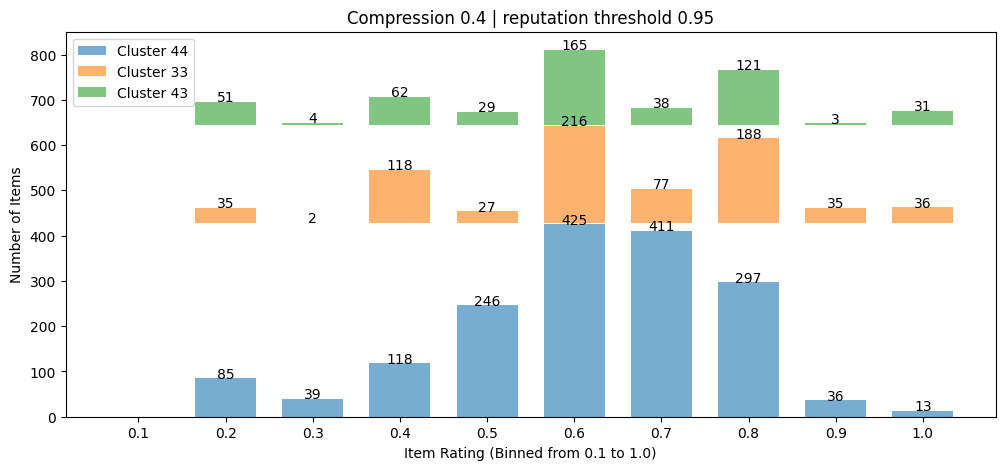

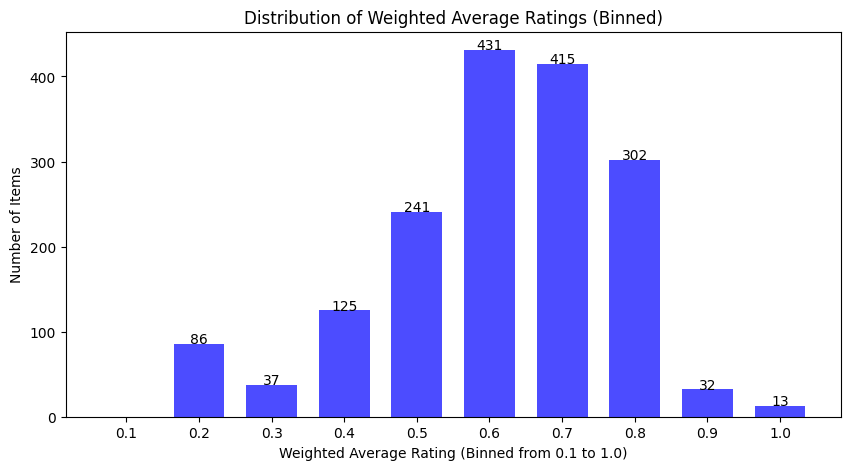

In [36]:
# Assuming user_groups is already defined
cluster_item_ratings = compute_cluster_ratings(df, user_groups)  # Step 1: Compute initial ratings

print("cluster_item_ratings: ", cluster_item_ratings)

cluster_item_ratings_reputation = compute_reputation_adjusted_ratings(df, cluster_item_ratings, user_groups)

print("cluster_item_ratings_reputation: ", cluster_item_ratings_reputation)

weighted_average_dict = compute_weighted_average_cluster_ratings(cluster_item_ratings_reputation, user_groups)

# round all clusters values 
rounded_ratings = round_ratings_to_one_decimal(cluster_item_ratings_reputation)

print("rounded_ratings: ", rounded_ratings)
print("len(rounded_ratings): ", len(rounded_ratings))

plot_top_3_clusters(rounded_ratings)  # Use actual dictionary
plot_weighted_average_distribution(weighted_average_dict)  # Use actual computed weighted averages


